In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is the second (perhaps third) attempt to read in track information and use it to predict the KDE used as input to pv-finder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_Ellipsoids.py uses poca_z, poca_x, poca_y, and six parameters A, B, C, D, E, and F describing the error ellipsoids are those defined at

from https://math.stackexchange.com/questions/1865188/how-to-prove-the-parallel-projection-of-an-ellipsoid-is-an-ellipse

Up to translation, a general ellipsoid can be written in the form

  𝐴$𝑥^2$ +𝐵$𝑦^2$+𝐶$𝑧^2$+2(𝐷𝑥𝑦+𝐸𝑥𝑧+𝐹𝑦𝑧)=1
  
for some positive-definite coefficient matrix 

$$
\left(\begin{array}{ccc}
A & D & E \\
D & B & F \\
E & F & C \\
\end{array}\right)
$$

Note that other conventions use a similarly named set of parameters with D, E, and and F denoting the coefficients of different combinations of $ x y $, etc., or without the factor of 2 in front of the cross-terms.  However, this is the convention we are using for pv-finder related work, as of early November, 20020


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Thu Jul  1 12:09:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   44C    P8    43W / 250W |   4984MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [5]:
n_epochs = 100
# How fast to learn
learning_rate = 1e-4

# Name is the output file name

n = 30
nOuts = [n]*11
nOut1, nOut2, nOut3, nOut4, nOut5, nOut6, nOut7, nOut8, nOut9, nOut10, nOut11 = nOuts
folder = time.strftime('%d%B%Y') + '_testing_DirtyDozen_first_learning_iterC_30_nodes_' + str(n_epochs) + '_epochs_' + str(learning_rate)
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'jgo_files/' + folder
output = Path(folder)


# Size of batches
batch_size = 64

Make the output directory if it does not exist:

In [6]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_E import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
loss = Loss(epsilon=3e-6, debug=False)

ct, child =  0    Linear(in_features=9, out_features=30, bias=True)
ct, child =  1    Linear(in_features=30, out_features=30, bias=True)
ct, child =  2    Linear(in_features=30, out_features=30, bias=True)
ct, child =  3    Linear(in_features=30, out_features=30, bias=True)
ct, child =  4    Linear(in_features=30, out_features=30, bias=True)
ct, child =  5    Linear(in_features=30, out_features=30, bias=True)
ct, child =  6    Linear(in_features=30, out_features=30, bias=True)
ct, child =  7    Linear(in_features=30, out_features=30, bias=True)
ct, child =  8    Linear(in_features=30, out_features=30, bias=True)
ct, child =  9    Linear(in_features=30, out_features=30, bias=True)
ct, child =  10    Linear(in_features=30, out_features=30, bias=True)
ct, child =  11    Linear(in_features=30, out_features=4000, bias=True)


Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

## pretrained_dict = torch.load('ML/19October_testing_loss_C_500epochs_more_learning/19October_testing_loss_C_500epochs_more_learning_final.pyt')
## pretrained_dict = torch.load('ML/24October_testing_SevenLayerCake_first_learning_50epochs/24October_testing_SevenLayerCake_first_learning_50epochs_44.pyt')

##pretrained_dict = torch.load('ML/24October_testing_SevenLayerCake_first_learning_next1000epochs/24October_testing_SevenLayerCake_first_learning_next1000epochs_976.pyt')
## pretrained_dict = torch.load('ML/24October_testing_SevenLayerCake_first_learning_iter4_2500epochs_1em5/24October_testing_SevenLayerCake_first_learning_iter4_2500epochs_1em5_final.pyt')
## pretrained_dict = torch.load('ML/25October_testing_SevenLayerCake_first_learning_iter0_1000epochs_lossE/25October_testing_SevenLayerCake_first_learning_iter0_1000epochs_lossE_503.pyt')


## pretrained_dict = torch.load('ML/25October_testing_SevenLayerCake_first_learning_iter0_1000epochs_lossE/25October_testing_SevenLayerCake_first_learning_iter0_1000epochs_lossE_final.pyt')

## pretrained_dict = torch.load('ML/25October_testing_SevenLayerCake_first_learning_iter2_100epochs_lossE/25October_testing_SevenLayerCake_first_learning_iter2_100epochs_lossE_final.pyt')

## pretrained_dict = torch.load('ML/25October_testing_SevenLayerCake_first_learning_iter2_2nd_100epochs_lossE_Adam/25October_testing_SevenLayerCake_first_learning_iter2_2nd_100epochs_lossE_Adam_final.pyt')

## pretrained_dict = torch.load('ML/25October_testing_SevenLayerCake_first_learning_iter3_4000epochs_lossE_Adam/25October_testing_SevenLayerCake_first_learning_iter3_4000epochs_lossE_Adam_final.pyt')

##  results from the previous model were fluctuating, so choose epoch with relatively low costs

##pretrained_dict = torch.load('ML/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3_220.pyt')





# #  the next model had fluctuations near the end, but the final epoch is within striking distance of the lowest cost
# pretrained_dict = torch.load('ML/06November_testing_DirtyDozen_first_learning_iterB_20epochs_1em6/06November_testing_DirtyDozen_first_learning_iterB_20epochs_1em6_final.pyt')
# print(" ")
# print("  for pretrained_dict")
# index = 0
# for k,v in pretrained_dict.items():
#     print("index, k =  ",index,"  ",k)
#     index = index+1
 

# ##print("model_dict instantiated")
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# print("pretrained_dict iterated")
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# ##
# #   when starting from a model with a fully connected last layer rather than a convolutional layer
# # 3. load the new state dict
# #   need to use strict=False as the two models state model attributes do not agree exactly
# #   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

# model.load_state_dict(pretrained_dict,strict=False)

output =  jgo_files/29June2021_testing_DirtyDozen_first_learning_iterC_30_nodes_100_epochs_0.0001
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12.weight
index, k =   23    layer12.bias


In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:

## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                           device=device,
                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(18000,None)
                           )


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 29.23 s
outer loop X.shape =  (20000, 9, 600)
Constructing 2000 event dataset took 0.06802 s
x_t.shape =  torch.Size([2000, 9, 600])
x_t.shape[0] =  2000
x_t.shape[1] =  9
x_t.shape =  torch.Size([2000, 9, 600])


with torch.no_grad():
    counter = 0
    event = 0
    print("train_loader = ",train_loader)
    for inputs, labels in train_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        for iEvt in range(nEvts):
            y_pred = outputs[iEvt,:]
            y_pred = y_pred.cpu().numpy()
            
            event = event +1
##            print("event = ",event)
            if (event<5):
                plt.figure()
                plt.plot(y_pred[0:50])
                plt.show()
                
##                print("  point AA ")
                features = inputs[iEvt,:]
                features = features[np.newaxis,:,:]
                
                
                print("features.shape = ",features.shape)
                
                output_A = model(features)
                y_prime = output_A[0,:]
                y_prime = y_prime.cpu().numpy()
                plt.figure()
                plt.plot(y_prime[0:50], color="r")
                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
        counter = counter+1
        
        
        

<IPython.core.display.Javascript object>


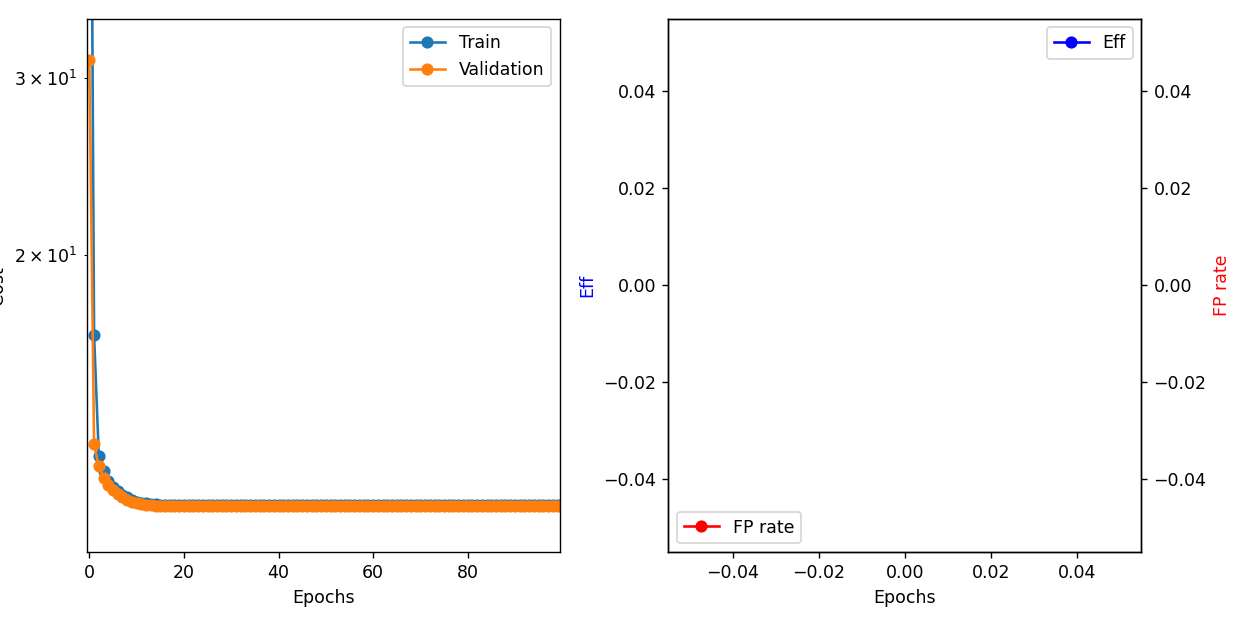

In [16]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [17]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 282, val = 32


Number of batches: train = 282, val = 32


Epoch 0: train=111.338, val=31.2643, took 8.3507 s


Epoch 1: train=16.6242, val=12.9354, took 8.0878 s


Epoch 2: train=12.5984, val=12.3016, took 8.1468 s


Epoch 3: train=12.1598, val=11.9835, took 8.2955 s


Epoch 4: train=11.9036, val=11.7793, took 8.2073 s


Epoch 5: train=11.7357, val=11.6369, took 8.2126 s


Epoch 6: train=11.613, val=11.5328, took 8.1745 s


Epoch 7: train=11.5205, val=11.4519, took 8.1777 s


Epoch 8: train=11.4529, val=11.3948, took 8.1916 s


Epoch 9: train=11.3982, val=11.3404, took 8.2349 s


Epoch 10: train=11.3455, val=11.2983, took 8.24 s


Epoch 11: train=11.3144, val=11.2765, took 8.1795 s


Epoch 12: train=11.2943, val=11.2568, took 8.2335 s


Epoch 13: train=11.2793, val=11.2466, took 8.2326 s


Epoch 14: train=11.2698, val=11.2402, took 8.2924 s


Epoch 15: train=11.2641, val=11.2342, took 8.3478 s


Epoch 16: train=11.2586, val=11.232, took 8.3364 s


Epoch 17: train=11.2564, val=11.23, took 8.2998 s


Epoch 18: train=11.2552, val=11.2295, took 8.2422 s


Epoch 19: train=11.2541, val=11.2281, took 8.3473 s


Epoch 20: train=11.252, val=11.2264, took 8.3053 s


Epoch 21: train=11.2515, val=11.2261, took 8.2592 s


Epoch 22: train=11.2511, val=11.225, took 8.3764 s


Epoch 23: train=11.2505, val=11.2248, took 8.2937 s


Epoch 24: train=11.2504, val=11.2246, took 8.3503 s


Epoch 25: train=11.2503, val=11.2245, took 8.2463 s


Epoch 26: train=11.2502, val=11.2244, took 8.2463 s


Epoch 27: train=11.2502, val=11.2244, took 8.2621 s


Epoch 28: train=11.2502, val=11.2243, took 8.2913 s


Epoch 29: train=11.2501, val=11.2243, took 8.3318 s


Epoch 30: train=11.2501, val=11.2242, took 8.3003 s


Epoch 31: train=11.2501, val=11.2242, took 8.3541 s


Epoch 32: train=11.25, val=11.2241, took 8.4184 s


Epoch 33: train=11.25, val=11.2241, took 8.4527 s


Epoch 34: train=11.25, val=11.224, took 8.4198 s


Epoch 35: train=11.2499, val=11.224, took 8.506 s


Epoch 36: train=11.2499, val=11.224, took 8.488 s


Epoch 37: train=11.2498, val=11.2239, took 8.6761 s


Epoch 38: train=11.2498, val=11.2239, took 8.7253 s


Epoch 39: train=11.2498, val=11.2238, took 8.7267 s


Epoch 40: train=11.2497, val=11.2238, took 8.6512 s


Epoch 41: train=11.2497, val=11.2238, took 8.5328 s


Epoch 42: train=11.2497, val=11.2237, took 8.3124 s


Epoch 43: train=11.2496, val=11.2237, took 8.3746 s


Epoch 44: train=11.2496, val=11.2237, took 8.3189 s


Epoch 45: train=11.2496, val=11.2236, took 8.3717 s


Epoch 46: train=11.2495, val=11.2236, took 8.3938 s


Epoch 47: train=11.2495, val=11.2236, took 8.2661 s


Epoch 48: train=11.2495, val=11.2235, took 8.2644 s


Epoch 49: train=11.2495, val=11.2235, took 8.2963 s


Epoch 50: train=11.2494, val=11.2235, took 8.3572 s


Epoch 51: train=11.2494, val=11.2234, took 8.3192 s


Epoch 52: train=11.2494, val=11.2234, took 8.3127 s


Epoch 53: train=11.2493, val=11.2234, took 8.251 s


Epoch 54: train=11.2493, val=11.2233, took 8.3464 s


Epoch 55: train=11.2493, val=11.2233, took 8.3947 s


Epoch 56: train=11.2492, val=11.2233, took 8.4121 s


Epoch 57: train=11.2492, val=11.2233, took 8.436 s


Epoch 58: train=11.2492, val=11.2232, took 8.4572 s


Epoch 59: train=11.2492, val=11.2232, took 8.3592 s


Epoch 60: train=11.2491, val=11.2232, took 8.3563 s


Epoch 61: train=11.2491, val=11.2231, took 8.3348 s


Epoch 62: train=11.2491, val=11.2231, took 8.2895 s


Epoch 63: train=11.249, val=11.2231, took 8.3064 s


Epoch 64: train=11.249, val=11.2231, took 8.348 s


Epoch 65: train=11.249, val=11.223, took 8.3249 s


Epoch 66: train=11.249, val=11.223, took 8.4501 s


Epoch 67: train=11.2489, val=11.223, took 8.3033 s


Epoch 68: train=11.2489, val=11.2229, took 8.268 s


Epoch 69: train=11.2489, val=11.2229, took 8.3978 s


Epoch 70: train=11.2489, val=11.2229, took 8.3559 s


Epoch 71: train=11.2488, val=11.2229, took 8.327 s


Epoch 72: train=11.2488, val=11.2228, took 8.43 s


Epoch 73: train=11.2488, val=11.2228, took 8.6279 s


Epoch 74: train=11.2488, val=11.2228, took 8.443 s


Epoch 75: train=11.2487, val=11.2227, took 8.6599 s


Epoch 76: train=11.2487, val=11.2227, took 8.6965 s


Epoch 77: train=11.2487, val=11.2227, took 8.5314 s


Epoch 78: train=11.2486, val=11.2227, took 8.6575 s


Epoch 79: train=11.2486, val=11.2226, took 8.858 s


Epoch 80: train=11.2486, val=11.2226, took 8.773 s


Epoch 81: train=11.2486, val=11.2226, took 8.8555 s


Epoch 82: train=11.2485, val=11.2226, took 8.722 s


Epoch 83: train=11.2485, val=11.2225, took 8.5092 s


Epoch 84: train=11.2485, val=11.2225, took 8.5017 s


Epoch 85: train=11.2485, val=11.2225, took 8.3602 s


Epoch 86: train=11.2484, val=11.2225, took 8.324 s


Epoch 87: train=11.2484, val=11.2224, took 8.3232 s


Epoch 88: train=11.2484, val=11.2224, took 8.3457 s


Epoch 89: train=11.2484, val=11.2224, took 8.2942 s


Epoch 90: train=11.2483, val=11.2223, took 8.2925 s


Epoch 91: train=11.2483, val=11.2223, took 8.3451 s


Epoch 92: train=11.2483, val=11.2223, took 8.3802 s


Epoch 93: train=11.2483, val=11.2223, took 8.3254 s


Epoch 94: train=11.2482, val=11.2222, took 8.392 s


Epoch 95: train=11.2482, val=11.2222, took 8.3137 s


Epoch 96: train=11.2482, val=11.2222, took 8.3129 s


Epoch 97: train=11.2482, val=11.2222, took 8.2737 s


Epoch 98: train=11.2481, val=11.2221, took 8.2791 s


Epoch 99: train=11.2481, val=11.2221, took 8.34 s



Go ahead and save the final model (even though it was also saved above):

In [18]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [19]:
results.to_hdf(output / f'{name}_stats.hdf5', 'results')
print(results)

    epoch        cost        val      time
0     0.0  111.338458  31.264314  8.350688
1     1.0   16.624219  12.935409  8.087822
2     2.0   12.598360  12.301557  8.146834
3     3.0   12.159786  11.983470  8.295506
4     4.0   11.903593  11.779278  8.207290
..    ...         ...        ...       ...
95   95.0   11.248218  11.222211  8.313746
96   96.0   11.248194  11.222184  8.312854
97   97.0   11.248169  11.222158  8.273691
98   98.0   11.248144  11.222131  8.279133
99   99.0   11.248120  11.222105  8.340048

[100 rows x 4 columns]


Save the plot above:

<IPython.core.display.Javascript object>


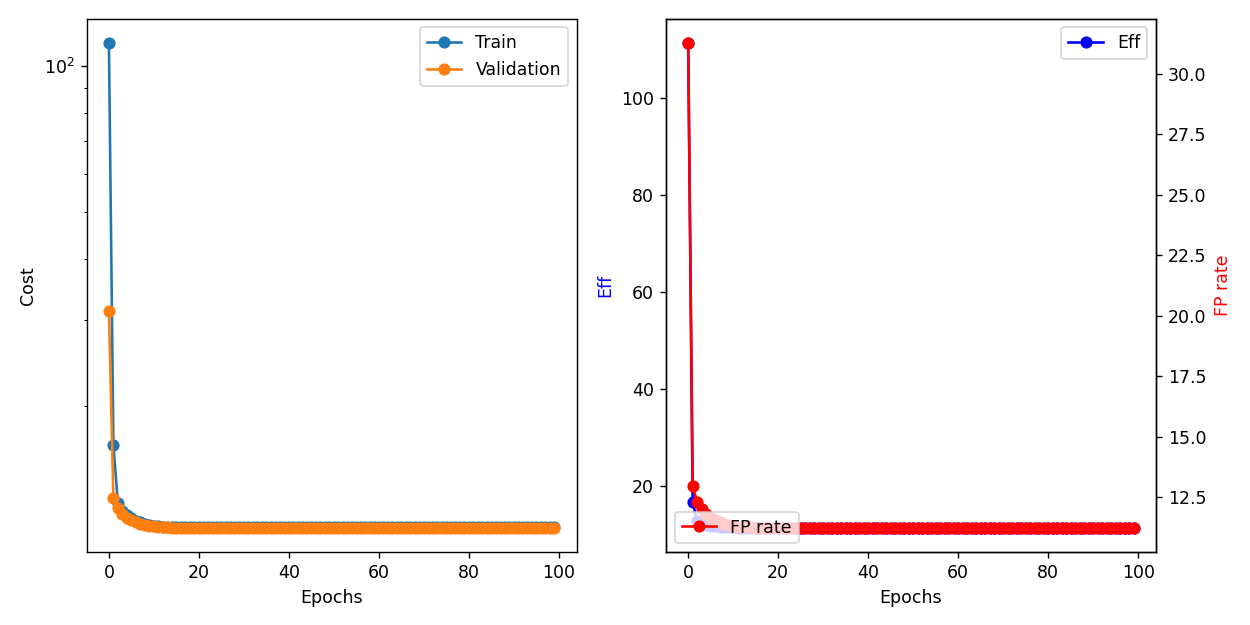

In [20]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))